# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
d_type='processed'     # 'processed', 'synthetic'
video_d=True            # Video = True , Image = False 
test_data,number_data_points= False,500

t_btw_frm=0.05

checking_on=False

data_augmentation= True
number_new_d=150

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   
     

# CNN

### GENERATE TRAIN DATA

In [4]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


In [5]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):
        print(r,int(y),np.shape(x),type(x))

# DATA AUGMENTATION

In [6]:
#video = tf.image.random_brightness(video, max_delta=0.9)    # OK
#video = tf.image.random_contrast(video, lower=0.5, upper=10)   # OK

if data_augmentation:

    aug_recs=[]
    aug_X_train=[]
    aug_Y_train=np.ones(number_new_d)

    idx_Y_1 = np.where(y_train == 1)[0]
    idx_Y_1 = np.random.choice(idx_Y_1, size=number_new_d, replace=False)

    for index in idx_Y_1:

        video=CNN_lib.random_flip(x_train[index])
        aug_X_train.append(video)
        aug_recs.append('AUG_'+rcs[index])

    aug_X_train=np.array(aug_X_train)

In [7]:
if data_augmentation:

    y_train = np.concatenate((y_train, aug_Y_train))
    x_train=np.concatenate((x_train, aug_X_train), axis=0)
    rcs=rcs+aug_recs

### CHECK 1

In [8]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):
        print(r,int(y),np.shape(x),type(x))

In [9]:
if checking_on:

    rec_elm='I70'
    idx=rcs.index(rec_elm)
    y_train[idx]

In [10]:
if checking_on:fig_lib.vid_show(x_train[idx],t_btw_frm=t_btw_frm)

In [11]:
if test_data:

    total_data_points=len(y_train)
    test_len=total_data_points-number_data_points
    
    Xx_train=x_train[0:number_data_points]
    Yy_train=y_train[0:number_data_points]
    recs=rcs[0:number_data_points]

else:

    Xx_train=x_train
    Yy_train=y_train


## DATA SHUFFLE

In [12]:
idx_permut = np.random.permutation(len(Xx_train))
Xx_train,Yy_train=Xx_train[idx_permut],Yy_train[idx_permut]
recs=list(np.take(rcs, idx_permut))


### CHECK 2

In [13]:
if checking_on:

    rec_elm='AUG_I70'
    idx=recs.index(rec_elm)
    print(idx,Yy_train[idx])

In [14]:
if checking_on:fig_lib.vid_show(Xx_train[idx],t_btw_frm=t_btw_frm)

## DATA SPLIT

In [15]:
# X_train,Y_train,X_eval,Y_eval


test_size=0.2


In [16]:

X_train, X_eval, Y_train, Y_eval = train_test_split(Xx_train, Yy_train, test_size=test_size, shuffle=False) #,random_state=42)

print('Train data:',len(Y_train),'Evaluation data:',len(Y_eval))
if test_data:print('Test_len:',test_len)

Train data: 648 Evaluation data: 162


 Train data shape: (648, 40, 160, 160, 1)  Validation data shape: (162, 40, 160, 160, 1)


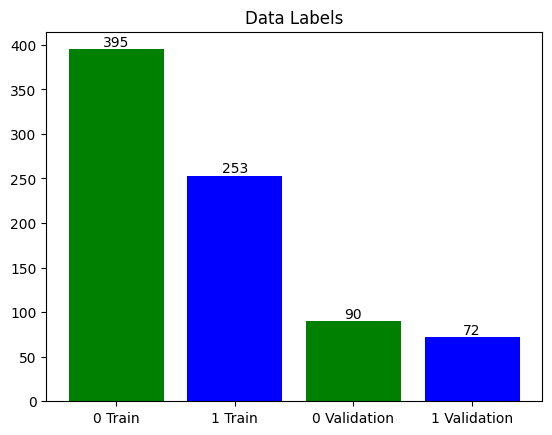

In [17]:
# check data

zeros_count = np.sum(Y_train == 0)
ones_count = np.sum(Y_train == 1)
zeros_count_val = np.sum(Y_eval == 0)
ones_count_val = np.sum(Y_eval == 1)

labels = ['0 Train', '1 Train','0 Validation', '1 Validation']
print(' Train data shape:', np.shape(X_train),' Validation data shape:', np.shape(X_eval))

plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['green', 'blue','green', 'blue'])

for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Data Labels')
plt.show()

### PARAMETERS

In [18]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D


In [19]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epch=9


### MODEL

In [20]:
gc.collect()

3165

In [21]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',input_shape=(max_frm_n, HEIGHT, WIDTH, 1)),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Dropout(0.2),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 158, 158, 16   448       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 19, 79, 79, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 77, 77, 32)    4640      
                                                                 
 dropout (Dropout)           (None, 19, 77, 77, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 9, 38, 38, 32)     0         
 g3D)                                                            
                                                       

In [22]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

In [23]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)            


### TRAINNING

In [24]:
history =model.fit(X_train, Y_train, epochs=epch, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/9


21/21 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5895
Epoch 1: val_loss improved from inf to 0.68331, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
21/21 [==============================] - 52s 2s/step - loss: 0.6846 - accuracy: 0.5895 - val_loss: 0.6833 - val_accuracy: 0.5556
Epoch 2/9


c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6157
Epoch 2: val_loss did not improve from 0.68331
21/21 [==============================] - 43s 2s/step - loss: 0.6445 - accuracy: 0.6157 - val_loss: 0.6863 - val_accuracy: 0.5679
Epoch 3/9
16/21 [=====================>........] - ETA: 10s - loss: 0.5855 - accuracy: 0.6934

### EVALUATE MODEL

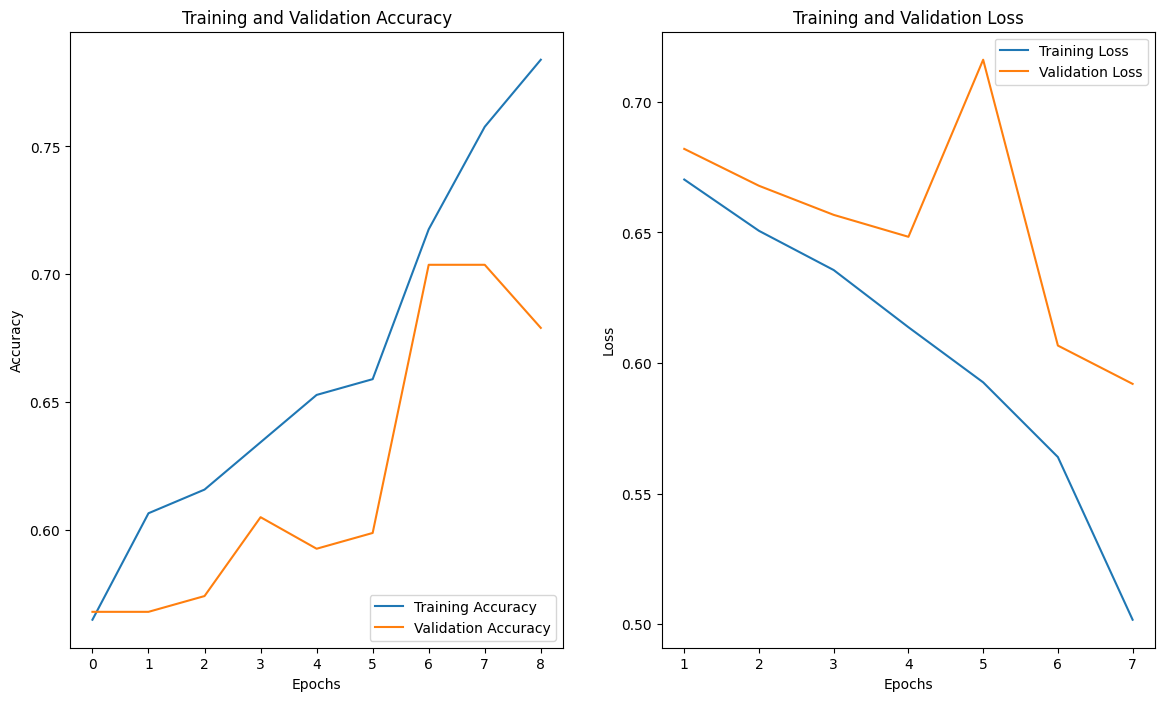

In [ ]:
fg_size=(14,8)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epch)

plt.figure(figsize=fg_size)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)
plt.plot(epochs_range[1:-1], loss[1:-1], label='Training Loss')
plt.plot(epochs_range[1:-1], val_loss[1:-1], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

6/6 - 2s - loss: 0.5947 - accuracy: 0.6790 - 2s/epoch - 391ms/step
Loss: 0.5947468280792236 Accuracy: 0.6790123581886292


### BEST EPOCH

In [ ]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

6/6 - 2s - loss: 0.5920 - accuracy: 0.7037 - 2s/epoch - 401ms/step
Loss: 0.592025101184845 Accuracy: 0.7037037014961243


In [ ]:
performance_d={'NAME':mdl,
               'ACCURACY':test_accuracy,
               'LOSS':test_loss,
               'HEIGHT':HEIGHT,
               'WIDTH':WIDTH}

performance_d

{'NAME': 'video_conv3D',
 'ACCURACY': 0.7037037014961243,
 'LOSS': 0.592025101184845,
 'HEIGHT': 160,
 'WIDTH': 160}

# VALIDATION DATA

In [ ]:
predictions = model.predict(X_eval)
print(predictions)



6/6 [==============================] - 2s 367ms/step
[[0.3767859 ]
 [0.35671753]
 [0.0657134 ]
 [0.17180063]
 [0.6144113 ]
 [0.20004727]
 [0.4282858 ]
 [0.35302025]
 [0.29671016]
 [0.18351324]
 [0.24463926]
 [0.40636   ]
 [0.40731803]
 [0.20896271]
 [0.5450688 ]
 [0.15743043]
 [0.48622406]
 [0.6590302 ]
 [0.2039886 ]
 [0.10163848]
 [0.44134974]
 [0.68597376]
 [0.68088895]
 [0.73223174]
 [0.5981034 ]
 [0.5601483 ]
 [0.7261682 ]
 [0.67125946]
 [0.18643153]
 [0.55971956]
 [0.20142458]
 [0.38107386]
 [0.68603665]
 [0.15361851]
 [0.16369109]
 [0.43776277]
 [0.14326173]
 [0.1596423 ]
 [0.39819932]
 [0.7142525 ]
 [0.5059691 ]
 [0.6742972 ]
 [0.4903404 ]
 [0.56756145]
 [0.66024494]
 [0.13070643]
 [0.52253103]
 [0.6890822 ]
 [0.24335305]
 [0.5228121 ]
 [0.0510905 ]
 [0.44687468]
 [0.5724154 ]
 [0.24137315]
 [0.5067374 ]
 [0.23268999]
 [0.3969388 ]
 [0.68122834]
 [0.26256296]
 [0.51056087]
 [0.30646247]
 [0.40415847]
 [0.4669551 ]
 [0.6771907 ]
 [0.2927091 ]
 [0.55555135]
 [0.52301276]
 [0.65959

## ROC CURVE

In [ ]:

fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)

roc_auc_false = auc(fpr_val, tpr_val)
roc_auc_thresholds = auc(thresholds_val, tpr_val)

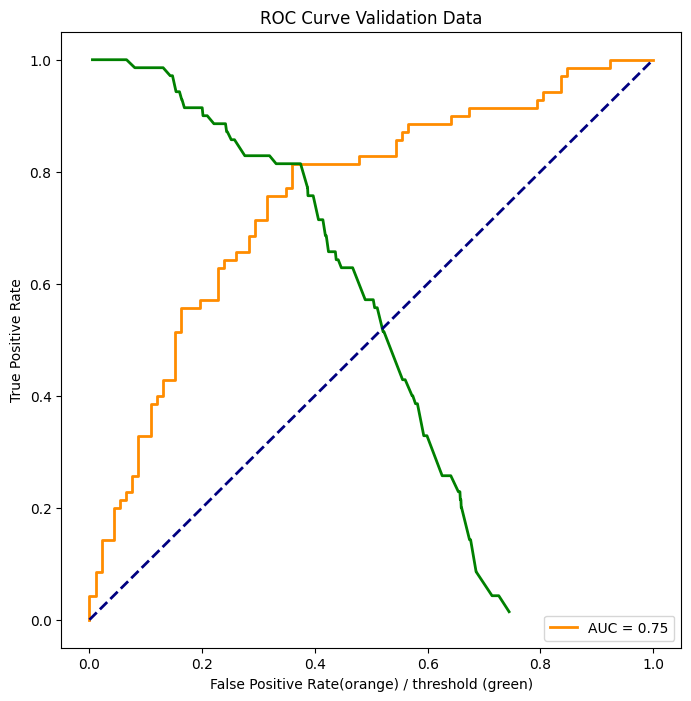

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'AUC = {roc_auc_false:.2f}')
plt.plot(thresholds_val, tpr_val, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate(orange) / threshold (green)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation Data')
plt.legend(loc='lower right')
plt.show()

#  FORECAST EVALUATION

In [ ]:
predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [ ]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[52 40]
 [13 57]]
Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.57      0.66        92
         1.0       0.59      0.81      0.68        70

    accuracy                           0.67       162
   macro avg       0.69      0.69      0.67       162
weighted avg       0.71      0.67      0.67       162



In [ ]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [ ]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]
print(correct_labels_val)

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]


In [ ]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


OK, 109
BAD, 53
Ratio forecast: 2.056603773584906
Ratio labeling: 1.3142857142857143


## SINGLE FORECAST

In [ ]:
rec_elm=['I1','I28','I70','109897_1','670615_10']
idx_list=[]
for element in rec_elm:
    idx_list.append(recs.index(element))

label_list=y_train[idx_list]
print(idx_list,label_list)

[132, 633, 552, 669, 589] [0. 0. 1. 1. 0.]


In [ ]:
idx_val=round((1-test_size)*len(y_train))+1
print(f'data lengh: {len(y_train)} , idx validation start: {idx_val} ')
print(f' Record: {rec_elm} , index: {idx_list}, real label: {label_list}')

data lengh: 810 , idx validation start: 649 
 Record: ['I1', 'I28', 'I70', '109897_1', '670615_10'] , index: [132, 633, 552, 669, 589], real label: [0. 0. 1. 1. 0.]


In [ ]:
nuevo_video = np.expand_dims(X_eval[max(idx_list)-idx_val], axis=0)

# Realizar la predicción
prediccion = model.predict(nuevo_video)
prediccion

1/1 [==============================] - 0s 42ms/step


array([[0.44134966]], dtype=float32)